# K Nearest Neighbors

___

*Source: [James et al., An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) *

___
This is what KNN at its simplest looks like:

$ \Pr\,(Y = j\, |\, X = x_0) = \frac{1}{K} \sum_{k\, \in \, N_0}{I(y_k = j)} $

Which basically means that the probability of an observation $x_0$ to belong to class $j$, is the weighed sum of the "votes" given by points of class $j$ among the *k* closest.

That said, the more observations in $N_0$ (the closest *k* neighbors) belong to the class $j$ the more likely it is for $x_0$ to belong to class $j$ as well.
___

Let's try to fit this model with **CARET**!

In [3]:
source('src/lib.R')

As first steps, we retrieve the **CARET** model info and the toy datasets (see previous lesson)

In [4]:
df <- get_partitioned_df()
models <- getModelInfo()

To fit the *K Nearest Neighbors* model with **CARET** we'll use the **kknn** method (provided by [this](https://cran.r-project.org/web/packages/kknn/index.html) CRAN package).

In [5]:
models$kknn$label
models$kknn$library

[1] "k-Nearest Neighbors"

[1] "kknn"

Which **kknn** parameters are directly supported by **CARET**?

In [6]:
models$kknn$parameters

parameter,class,label
kmax,numeric,Max. #Neighbors
distance,numeric,Distance
kernel,character,Kernel


As described by this output **CARET** does not support directly the setting of *k* but with *kmax* provides a way to set the maximum number of neighbors (*kmax*) to use in the fitting procedure.

In order to see the effect of different fixed *k* values on the fitted models, here we use directly the *ks* parameter of **kknn** as follows:

In [7]:
model <-  train(
    y = df$spirals$y_train$class,
    x = df$spirals$x_train,
    method = "kknn",
    ks = 20,
    trControl = trainControl(classProbs =  TRUE)
)

model$finalModel


Call:
kknn::train.kknn(formula = .outcome ~ ., data = dat, kmax = param$kmax,     ks = 20, distance = param$distance, kernel = as.character(param$kernel))

Type of response variable: nominal
Minimal misclassification: 0.3
Best kernel: optimal
Best k: 20

We have fitted a *K Nearest Neighbor* with k = 10 on the *spirals* toy dataset! Try to change *k* and to change the dataset...

Note that we set the *trControl* in order to have the fitted probability as output and, as a consequence, we can now use this output to plot the fitted model against the toy dataset.

In order to do this we introduce the *plot_model* function that we'll use extensively in the next lessons:

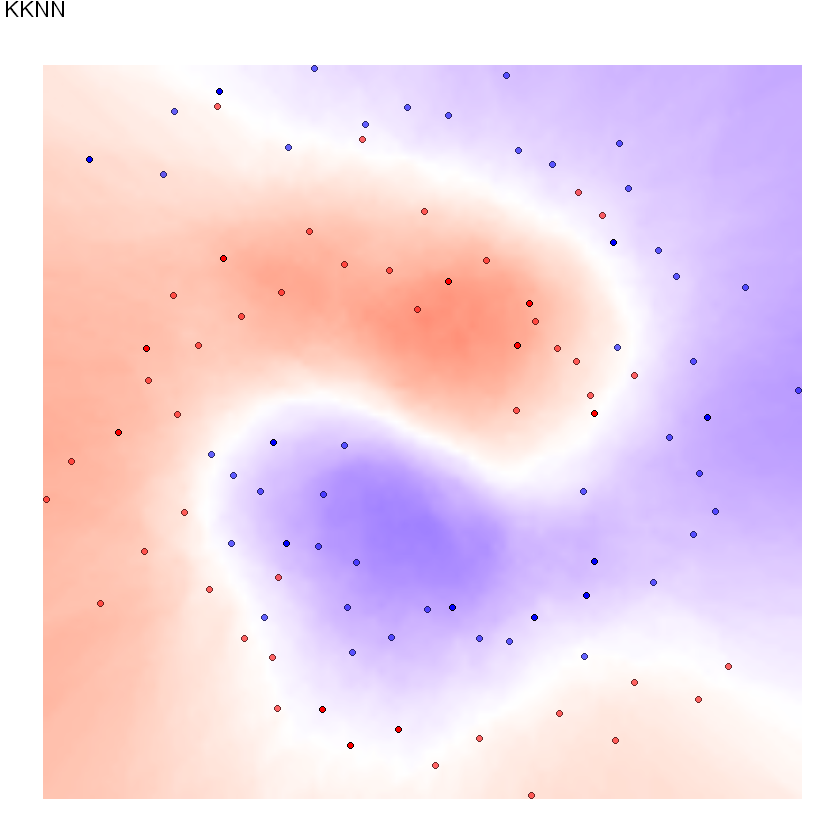

In [8]:
plot_model <- function(df, data_name, model){
    ## prepare prediction
    from <- 0
    to <- 1
    n <- 100
    grid_df <- expand.grid(
      x = seq(from, to, length.out = n),
      y = seq(from, to, length.out = n)
    )

    grid_df$prob = model %>% predict(grid_df %>% select(x,y), type = 'prob') %>% select(prob = class_1)

    ## Prepare plot dataset

    data_df <- lapply(
      data_name,
      function(data_name) {
        df <- df[[data_name]] 
        rbind(
          df$full_train %>% mutate(partition = "train"),
          df$full_val %>% mutate(partition = "val")
        )
      }
    ) %>% bind_rows

    ## plot data
    ggplot() + 
      geom_raster(data = grid_df, aes(x = x, y = y, fill = prob), interpolate = T, alpha = 0.7) +
      scale_fill_gradient2(low = "blue", mid = "white",
                           high = "red", midpoint = 0.5, space = "rgb",
                           na.value = "grey50", guide = "colourbar") +
      geom_point(data = data_df, aes(x = x, y = y, fill = 1- (as.numeric(factor(class)) - 1), alpha = partition), shape = 21) +
      scale_alpha_manual(values = c("train" = 0.6, "test" = 1)) +
      theme_void() + ggtitle(model$method %>% toupper) +
      theme(legend.position = "none")
}

plot_model(df, "spirals", model)

Pretty neat, isn't it? Well, a close look tells us that there are somewhere some points that are classified as belonging to the wrong class. This is not good. What can we do?

___
### Tweak KNN hyper parameters

In [46]:
model = train(y = df$spirals$y_train$class,
              x = df$spirals$x_train,
              method = 'kknn',
              ks = 1,
              trControl = trainControl(classProbs =  TRUE)
)

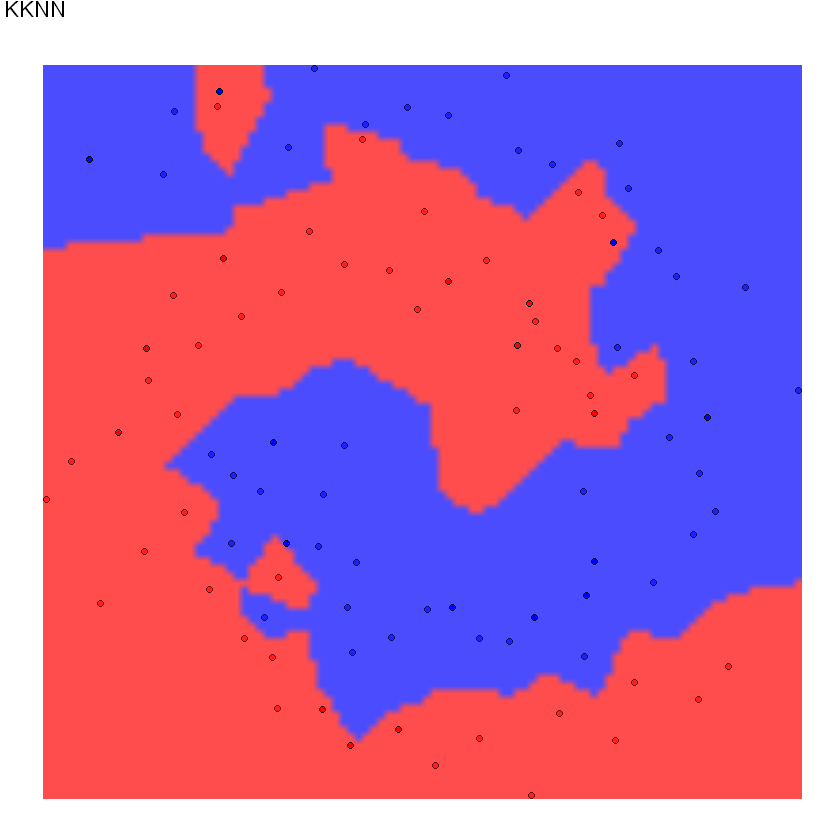

In [47]:
plot_model(df, "spirals", model)

That's way better! Can you see how the model is now much more confident on the position of the observations in the bottom right corner?

___

## Kernels + a few things about distances

Ok we now understand the meaning of *ks* (or, similarly *kmax*)...but there are other two parameters  (*distance* and *kernel*) among the **kknn** ones...what are they?

In [48]:
models$kknn$parameters

parameter,class,label
kmax,numeric,Max. #Neighbors
distance,numeric,Distance
kernel,character,Kernel


In the standard KNN algorithm all the neighbors have the same power in defining the output class. However in some cases may be very efficient to introduce a *weighting scheme* to give more discriminant power to the neighbors that are more similar to the to-classify observation $x_0$.
 
To parametrize the *weighting scheme* we can introduce a so-called *kernel function* $K: \mathbb{R^+} \rightarrow \mathbb{R^+}$ that satisfies two conditions:
 
* $K(d)$ gets its maximum for $d = 0$
* $K(d)$ decreases monotonously as $d \rightarrow +\infty$
 
Using this kernel function we can predict the class of $x_0$ given the $k$ neighbors in $N_0$ as:
 
$ p = \operatorname{argmax}_j\left\{\sum_{k \in N_0}{K(d(x_0, y_k))I(y_k = j)} \right\} $
 
Or define the probability:
 
$\Pr(Y = j | X = x_0) = \frac{\sum_{k \in N_0}K(d(x_0, y_k))I(y_k = j)}{\sum_{k \in N_0}K(d(x_0, y_k))}$
 
Where:
* $I$ is an *indicator function* which takes value $+1$ if the istance belongs to the first class and $-1$ otherwise.
* $d(x,y)$ is a distance function like the *euclidean distance*. However in different settings a different measure of distance may turn out being more effective. The *Minkowski* distance is a generalization of the concept of distance:
 
$d\left(x,y\right)=\left(\sum_{i=1}^n |x_i-y_i|^p\right)^{1/p}$
 
When $p = 2$ we have the *euclidean distance*, when $p = 1$ we have th *manhattan distance* and so on...
 
The choice of the *distance* function is a *hyperparameter* of the *Kernelised K-Nearest Neighbor*.
 
The other *hyperparameter* added by the KNN *kernelisation* regards the choice of kernel function $K(d)$.
 
These are three kernel function examples.
1. Rectangular kernel (standard KNN kernel)
2. Gaussian kernel
3. Parabolic kernel
 
![Standard KNN Kernel](fig/rectangular_kernel.png "title-1") ![Gaussian Kernel](fig/gaussian_kernel.png "title-2")![Epanechnikov (alias parabolic) Kernel](fig/epanechnikov_kernel.png "title-2")

___

To manipulate both the *type of kernel* and the *type of distance* in the hyperparameter setting phase, we must use a different implementation of the knn algorithm, obiouvsly availlable in CARET

In [49]:
## train the model

model = train(y = df$spirals$y_train$class,
              x = df$spirals$x_train,
              method = "kknn",
              tuneGrid = data.frame(
                  'kmax' = 5,
                  'distance' = 1,
                  'kernel' = c('epanechnikov')
              ),
              trControl = trainControl(classProbs =  TRUE)
)

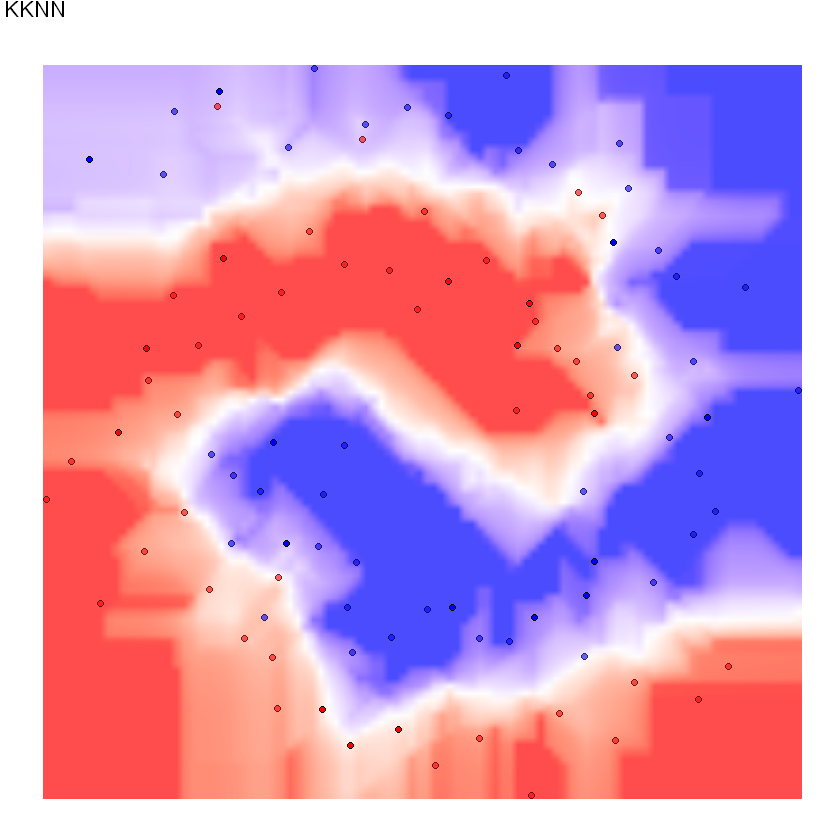

In [50]:
plot_model(df, "spirals", model)